In [1]:
# Import all libraries!
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil
import time
from urx.robotiq_two_finger_gripper import Robotiq_Two_Finger_Gripper
import logging
import urx


logging.basicConfig(level=logging.CRITICAL)
# HOW TO REMOVE LOGGING MESSAGES!!!?


moved to init position


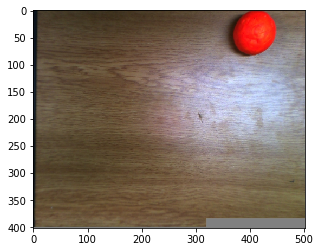

image recieved
pixel count: 5149
centerpoints at: x: 408 y: 40
top left points are: x: 408 y: 40
distance from center: x: 88 y: -200


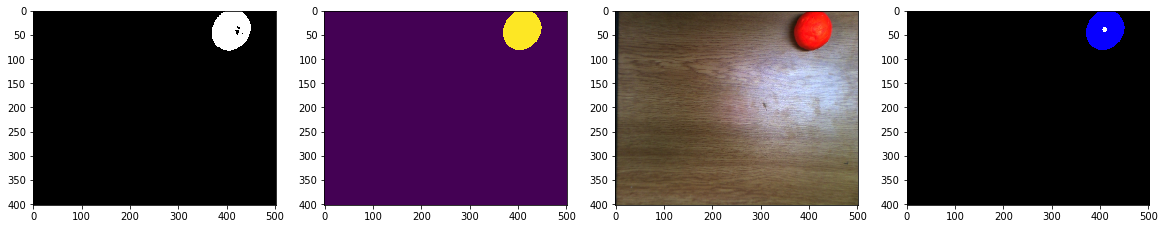

distances are:
[88, -200]
(0.12571428571428572, -0.15384615384615385)
moved to init position
moved to init position


Exception in thread Thread-95:
Traceback (most recent call last):
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\threading.py", line 801, in __bootstrap_inner
    self.run()
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\ursecmon.py", line 289, in run
    data = self._get_data()
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\ursecmon.py", line 336, in _get_data
    tmp = self._s_secondary.recv(1024)
timeout: timed out

Exception in thread Thread-72:
Traceback (most recent call last):
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\threading.py", line 801, in __bootstrap_inner
    self.run()
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\ursecmon.py", line 289, in run
    data = self._get_data()
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\ursecmon.py", line 336, in _get_data
    tmp = self._s_secondary.recv(1024)
timeout: timed out
Exception i

In [123]:
rob = rob_connect()
robotiqgrip = Robotiq_Two_Finger_Gripper(rob)

a = 0.5; v = 1



# robotiqgrip.open_gripper()

go_to_start(rob)
time.sleep(1)
get_image()

distance = detect_photos("red")

print("distances are:")
print(distance)

move_over_object(rob, distance[0], distance[1])

rotate_to_shape(rob)

rob.translate((0, 0, -0.30), acc=0.2, vel=0.2)

robotiqgrip.close_gripper()

go_to_start(rob)

rob.movej([1.6486937999725342, -2.4073990027057093, -1.8858941237079065, -0.36886865297426397, -4.742553655301229, 0.0471811443567276], acc = a, vel = v)

robotiqgrip.open_gripper()

go_to_start(rob)

# # pose = rob.getl()
# # print(pose)
# # pose[3] = pose[3] - 0.57
# # rob.movel(pose, acc = a, vel = v)

# rob.movel_tool([0, 0, 0, -0.43, 0, 0],acc=a, vel=v)

rob.close()

In [57]:
info

[['red', 'green', 'blue'],
 [[0.8771262168884277,
   -2.0213030020343226,
   -1.4906061331378382,
   -1.2683027426349085,
   -4.42512029806246,
   0.04676169902086258],
  [0.4146837890148163,
   -2.2203643957721155,
   -1.1402199904071253,
   -1.2519210020648401,
   -4.418092672024862,
   0.04676169902086258],
  [0.41464781761169434,
   -2.220388714467184,
   -1.1402562300311487,
   -1.2519210020648401,
   -4.418092672024862,
   0.04682162031531334]]]

In [15]:
## get robot back into init pos
test_robot(a = 1, v = 1)


('robot tcp is at pose: ', [-0.12146264711488897, -2.0197561422931116, -0.9036038557635706, -1.2455666700946253, -4.750923816357748, 0.050909362733364105])


In [122]:
def move_over_object(rob, x_diff, y_diff):
    '''
    Function to move over identified object
    '''
#     factor = 3025.0
#     factor = 1500
    
    x_diff = float(x_diff)/700
    y_diff = float(y_diff)/1300
    
    
    print(x_diff, y_diff)
    
    rob.translate((y_diff, x_diff, 0), acc=a, vel=v)
    

In [3]:
def teach_bins(rob):
    '''
    Allows user to move robot to placement of bins
    Also need to allow user to take photo of object!??
    '''
    colours = []
    bins = []
    n_bins = int(raw_input("Please enter the number of bins you have: "))
    for i in range(n_bins):
        rob.set_freedrive(1, timeout=60)
        colours.append(raw_input("Press color of bin when complete: "))
        bins.append(rob.getj())
        
    print("Completed all bins!")
    return [colours, bins]

In [101]:
def rotate_to_shape(rob):
    '''
    rotate robot gripper to face objects below
    '''
#     pose = rob.getj()
#     pose[3] = pose[3] - 0.57
#     rob.movej(pose, acc = a, vel = v)
    rob.movel_tool([0, 0, 0, -0.43, 0, 0],acc=a, vel=v)

In [24]:
def get_image():
    '''
    Recieve latest image and save it in a folder
    '''
    
    image_url = "http://192.168.1.6:4242/current.jpg?type=color"
    
    resp = requests.get(image_url, stream=True)
    # Open a local file with wb ( write binary ) permission.
    img_string = 'images/latest_image.jpg'
    local_file = open(img_string, 'wb')
    # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
    resp.raw.decode_content = True
    # Copy the response stream raw data to local image file.
    shutil.copyfileobj(resp.raw, local_file)
    # Remove the image url response object.
    del resp
    
    im = cv2.imread('images/latest_image.jpg')
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print("image recieved")

In [27]:
def detect_photos(colour):
    '''
    Read in latest image and detect blobs of the given colour
    return the distance to the top left blob in form [X_from_center, Y_from_center] else returns None
    '''

#     files = glob.glob("Images/*")[:10] # CHANGE THIS!
    f = "images/latest_image.jpg"

    # two ranges because red stretchs over the Hue colour range
    
    ##RED
    lower_red_1 = (0,100,50)
    upper_red_1 = (5,255,255)

    lower_red_2 = (170,100,50)
    upper_red_2 = (180,255,255)
    
    ##GREEN
    lower_green = (45, 100, 50)
    upper_green = (65, 255, 255)
    
    ##YELLOW
    lower_yellow = (20, 100, 50)
    upper_yellow = (45, 255, 255)



    # reading in image to RGB and HSV
    img_RGB = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
    img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)

    if colour == 'red':

        # Create two masks
        mask1 = cv2.inRange(img_HSV, lower_red_1, upper_red_1)
        mask2 = cv2.inRange(img_HSV, lower_red_2, upper_red_2)

        # XOR masks
        mask = cv2.bitwise_xor(mask1, mask2)
    elif colour == 'green':
        mask = cv2.inRange(img_HSV, lower_green, upper_green)

    elif colour == 'yellow':
        mask = cv2.inRange(img_HSV, lower_yellow, upper_yellow)


    # bitwise and with image
    result = cv2.bitwise_and(img_HSV, img_HSV, mask=mask)


    # put median blur over the top
    median = cv2.medianBlur(mask,23)

    print("pixel count: " + str(cv2.countNonZero(median)))

    if cv2.countNonZero(median) < 2000:
        print("no more objects in scene of colour: " + colour)
        return None

    # find connected components
    ret, labels = cv2.connectedComponents(median)

    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    #########################################################
    ## Finding Centers!
    ret,thresh = cv2.threshold(median,127,255,0)

    # find contours in the binary image
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    distance_min = 100000
    for c in contours:
        # calculate moments for each contour
        M = cv2.moments(c)

        # calculate x,y coordinate of center
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(labeled_img, (cX, cY), 5, (255, 255, 255), -1)

            distance_new = np.sqrt(cX**2 + cY**2)
            if distance_new < distance_min:
                distance_min = distance_new
                X_top_left = cX
                Y_top_left = cY

            print("centerpoints at: x: " + str(cX) + " y: " + str(cY))

    print("top left points are: x: " + str(X_top_left) + " y: " + str(Y_top_left))

    X_from_center = X_top_left - (640/2)
    Y_from_center = Y_top_left - (480/2)

    print("distance from center: x: " + str(X_from_center) + " y: " + str(Y_from_center))

    # print out figures
    figure = plt.figure(figsize=(20,20))
    plt.subplot(1, 4, 1)
    # mask
    plt.imshow(mask, cmap="gray")
    plt.subplot(1, 4, 2)
    # median blue
    plt.imshow(median)
    #original image
    plt.subplot(1, 4, 3)
    plt.imshow(img_RGB)
    # final 
    plt.subplot(1, 4, 4)
    plt.imshow(labeled_img)

    plt.show()

    return [X_from_center, Y_from_center]

In [7]:
def test_robot(a = 0.2, v = 0.3):
    '''
    Test to see if robot is behaving normally
    '''
    
    # defining joint angles of important positions
#     cam_init_pos = [-0.006403748189107716, -1.9564278761493128, -0.4473179022418421, -1.808915917073385, -4.750971380864279, 0.04987834393978119]
    cam_init_pos = [-0.12137872377504522, -2.0197680632220667, -0.9036515394793909, -1.24553090730776, -4.750875894223348, 0.050909362733364105]
    bucket_pos = [1.6486937999725342, -2.4073990027057093, -1.8858941237079065, -0.36886865297426397, -4.742553655301229, 0.0471811443567276]
    hardcode_object_loc = [-0.024045769368306935, -1.8617809454547327, -1.511141602193014, -1.4511950651751917, -4.672266546879904, 0.047373268753290176]
    bucket_pick = [-0.04573041597475225, -1.8159015814410608, -1.2815788427936, -1.4384973684894007, -4.67054266134371, 0.04719312861561775]

    # logging
#     logging.basicConfig(level=logging.WARN)

    # connecting to robot and initialising gripper
    while(1):
        try:
            rob = urx.Robot("192.168.1.6")
        except:
            print("didnt connect, try again")
            time.sleep(1)
        else:
            break
    
    robotiqgrip = Robotiq_Two_Finger_Gripper(rob)

#     # not sure what this does
#     rob.set_tcp((0,0,0,0,0,0))
#     rob.set_payload(0.5, (0,0,0))

    # initalise with gripper open
    robotiqgrip.open_gripper()

    # move to initial position
    rob.movej(cam_init_pos, acc = a, vel = v)


#     rob.movej(hardcode_object_loc, acc = a, vel = v)

#     robotiqgrip.close_gripper()

#     rob.movej(cam_init_pos, acc = a, vel = v)

#     rob.movej(bucket_pos, acc = a, vel = v)

#     robotiqgrip.open_gripper()



    pose = rob.getj()
    # pose = rob.get_pose()
    # pose = rob.get_orientation()
    print("robot tcp is at pose: ", pose)

    rob.close()

In [48]:
def go_to_start(rob):
#     cam_init_pos = [-0.12137872377504522, -2.0197680632220667, -0.9036515394793909, -1.24553090730776, -4.750875894223348, 0.050909362733364105]
    cam_init_pos = [0.03240422159433365, -1.9091947714435022, -0.9082844893084925, -1.3367517630206507, -4.72296387354006, 0.0019174760673195124]
    
    rob.movej(cam_init_pos, acc = a, vel = v)
    print("moved to init position")
    

In [8]:
def rob_connect():
    while(1):
        try:
            rob = urx.Robot("192.168.1.6")
        except:
            print("didnt connect, try again")
            time.sleep(1)
        else:
            robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
            return rob
    